In [14]:
import numpy as np
import pandas as pd
import csv
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
subject=[]
BETA=[]
PHI=[]
PERSEV=[]

In [3]:
def read_data(n):
    #数据文件在的位置
    action = []
    reward = []
    reward_B = []
    comparision = [] #r-r_b; 1:>=0, 0:<0
    num = str(100+n)
    file = pd.read_csv('E:/multi-bandit/RL_E1_preexp1_data/' + num + '.csv')
    name = 'sub (' +str(n) +').csv'
    action_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'choose_bandit.keys':
            action_index = i
    reward_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'subchoose':
            reward_index = i
    for i in range((file.shape[0])):

        if file.iloc[i,0] == 1 and file.iloc[i,action_index]!='None' :
            if file.iloc[i,action_index] == 'r':
                action.append(0)
            elif file.iloc[i,action_index] == 'f':
                action.append(1)
            elif file.iloc[i,action_index] == 'i':
                action.append(2)
            elif file.iloc[i,action_index] == 'j':
                action.append(3)
            else:
                print(file.iloc[i,action_index])
                print(i)
                raise ValueError('不能识别选项')
            reward.append(int(file.iloc[i,reward_index]))
            reward_B.append(int(file.iloc[i,reward_index+1]))
            if int(file.iloc[i,reward_index]) >= int(file.iloc[i,reward_index+1]):
                comparision.append(int(file.iloc[i,reward_index])-int(file.iloc[i,reward_index+1]))
            else:
                comparision.append(int(file.iloc[i,reward_index+1])-int(file.iloc[i,reward_index]))
        elif file.iloc[i,0] == 1 and file.iloc[i,action_index] =='None' :
            action.append(4)
            reward.append(0)
            reward_B.append(0)
            comparision.append(0)
    return action,reward,reward_B,comparision

In [4]:
def select_effictive_data(n):
    #数据文件在的位置
    effictive_range = 60
    action = []
    reward = []
    reward_B = []
    comparision = [] #r-r_b; 1:>=0, 0:<0
    num = str(100+n)
    file = pd.read_csv('E:/multi-bandit/RL_E1_preexp1_alldata/' + num + '.csv')
    name = 'sub (' +str(n) +').csv'
    action_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'choose_bandit.keys':
            action_index = i
    reward_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'subchoose':
            reward_index = i
    for i in range((file.shape[0])):

        if file.iloc[i,0] == 1 and file.iloc[i,action_index]!='None' :
            if file.iloc[i,action_index] == 'r':
                action.append(0)
            elif file.iloc[i,action_index] == 'f':
                action.append(1)
            elif file.iloc[i,action_index] == 'i':
                action.append(2)
            elif file.iloc[i,action_index] == 'j':
                action.append(3)
            else:
                print(file.iloc[i,action_index])
                print(i)
                raise ValueError('不能识别选项')
            reward.append(int(file.iloc[i,reward_index]))
            reward_B.append(int(file.iloc[i,reward_index+1]))
            if int(file.iloc[i,reward_index]) >= int(file.iloc[i,reward_index+1]):
                comparision.append(int(file.iloc[i,reward_index])-int(file.iloc[i,reward_index+1]))
            else:
                comparision.append(int(file.iloc[i,reward_index+1])-int(file.iloc[i,reward_index]))

    effictive = 1
    for i in range(len(action)-effictive_range):
        # print(same(action[i:i+effictive_range]))
        if not same(action[i:i+effictive_range]):
            effictive = 0
    if effictive==0:
        print(100+n)
def same(a):
    l = len(a)
    a = np.array(a).squeeze()
    x = 1
    for i in range(l):
        if a[i]==np.mean(a):
            x = x*x
        else:
            x = x*0
    if x==0:
        return True
    else:
        return False

In [5]:
for i in np.arange(1,47):
    select_effictive_data(i)

111
117
119
126
140
146


In [6]:
delete_subject = [10,16,18,25,39,45]

In [5]:
def rewards2comparison(action,reward,reward_B):
    for i in range(len(action)):
        if action[i]!=4:
            pass
    pass
def read_parameter(file_name):
    parameter_result = pd.read_csv(file_name)
    beta = []
    phi = []
    persev = []
    gamma = []
    for i in range(10):
        beta.append(parameter_result.iloc[i,1])
    for i in range(10):
        phi.append(parameter_result.iloc[i+10,1])
    for i in range(10):
        persev.append(parameter_result.iloc[i+20,1])
    for i in range(10):
        gamma.append(parameter_result.iloc[i+30,1])
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    gamma = np.array(gamma)
    return beta,phi,persev,gamma
    
def action_probability(Q,action,beta):
    return np.log(np.exp(Q[action]*beta)/(np.exp(Q[0]*beta)+np.exp(Q[1]*beta)+np.exp(Q[2]*beta)+np.exp(Q[3]*beta)))

def likelyhood(file_name):
    beta,phi,persev,gamma = read_parameter(file_name)
    subjects = 10
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s+1) 
        comparision = rewards2comparison(action,reward,reward_B)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                eb = phi[s] * sig
                pb = np.zeros((4))
                re = gamma[s] * v / np.sum(sig)
                if t>0:
                    if action[t-1]!=0:
                        pb[action[t-1]] = persev[s]
                loglikelyhood += action_probability((v+eb+pb+re),action[t],beta[s])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
            
def likelyhood_ru_c(file_name):
    beta,phi,persev,gamma = read_parameter(file_name)
    subjects = 10
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s+1) 
        comparision = rewards2comparison(action,reward,reward_B)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.mean(sig)*np.ones((4))
                re_sig = sig - min_sig
                eb = phi[s] * sig
                pb = np.zeros((4))
                re = gamma[s] * np.ones((4))
                if t>0:
                    if action[t-1]!=0:
                        pb[action[t-1]] = persev[s]
                loglikelyhood += action_probability((v+eb+pb+re),action[t],beta[s])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
            
            


In [193]:
a = np.ones((4))*2
print(a)
a = np.sqrt(np.square(a)+5)
print(a)

[2. 2. 2. 2.]
[3. 3. 3. 3.]


In [239]:
reward_di_plus = []
reward_di_neg = []
N = 0
N_ = 0
for i in range(10):
    _,reward,reward_B,_ = read_data(i+1)
    r = 0
    n = 0
    r_ = 0
    n_ = 0
    for j in range(len(reward)) :
        if reward[j] > reward_B[j]:
            r += (reward[j]-reward_B[j])
            n += 1
        elif reward[j] < reward_B[j] :
            r_ += (reward_B[j]-reward[j])
            n_ +=1
    r = r/n
    r_ = r_/n_
    N+=n
    N_+=n_
    print(n,n_)
    reward_di_plus.append(r)
    reward_di_neg.append(r_)
reward_di_plus = np.array(reward_di_plus)
reward_di_neg = np.array(reward_di_neg)
print(N,N_)

88 53
72 70
51 91
65 72
96 45
44 91
47 96
41 103
63 76
41 102
608 799


In [5]:
simulation_zero = pd.read_csv('./simulation_comparision_zero_bayesian_learning_pystan.csv')
simulation_plus = pd.read_csv('./simulation_comparision_plus_bayesian_learning_pystan.csv')
simulation_neg = pd.read_csv('./simulation_comparision_neg_bayesian_learning_pystan.csv')

In [6]:
beta_1 = []
phi_1 = []
persev_1 = []
gamma_1 = []
beta_0 = []
phi_0 = []
persev_0 = []
gamma_0 = []
beta = []
phi = []
persev = []
gamma = []

for i in range(10):
    beta_1.append(simulation_plus.iloc[i,1])
for i in range(10):
    phi_1.append(simulation_plus.iloc[i+10,1])
for i in range(10):
    persev_1.append(simulation_plus.iloc[i+20,1])
for i in range(10):
    gamma_1.append(simulation_plus.iloc[i+30,1])
for i in range(10):
    beta_0.append(simulation_neg.iloc[i,1])
for i in range(10):
    phi_0.append(simulation_neg.iloc[i+10,1])
for i in range(10):
    persev_0.append(simulation_neg.iloc[i+20,1])
for i in range(10):
    gamma_0.append(simulation_neg.iloc[i+30,1])
    
for i in range(10):
    beta.append(simulation_zero.iloc[i,1])
for i in range(10):
    phi.append(simulation_zero.iloc[i+10,1])
for i in range(10):
    persev.append(simulation_zero.iloc[i+20,1])
for i in range(10):
    gamma.append(simulation_zero.iloc[i+30,1])
    
beta_0 = np.sort(np.array(beta_0))
phi_0 = np.sort(np.array(phi_0))
persev_0 = np.sort(np.array(persev_0))
gamma_0 = np.sort(np.array(gamma_0))

beta_1 = np.sort(np.array(beta_1))
phi_1 = np.sort(np.array(phi_1))
persev_1 = np.sort(np.array(persev_1))
gamma_1 = np.sort(np.array(gamma_1))

beta = np.sort(np.array(beta))
phi = np.sort(np.array(phi))
persev = np.sort(np.array(persev))
gamma = np.sort(np.array(gamma))

In [15]:
comparision_result = pd.read_csv('./formal_contrast_ru_c.csv')
comparision_0_result = pd.read_csv('./formal_contrast_ru_c_0.csv')

In [6]:
comparision_result = pd.read_csv('./nhb_contrast.csv')
comparision_0_result = pd.read_csv('./nhb_ru_no_gamma.csv')

In [7]:
num_subject = 60

In [8]:
beta_1 = []
phi_1 = []
persev_1 = []

beta_0 = []
phi_0 = []
persev_0 = []

beta = []
phi = []
persev = []


for i in range(num_subject):
    beta_1.append(comparision_result.iloc[i,1])
for i in range(num_subject):
    phi_1.append(comparision_result.iloc[i+num_subject,1])
for i in range(num_subject):
    persev_1.append(comparision_result.iloc[i+num_subject*2,1])

for i in range(num_subject):
    beta_0.append(comparision_result.iloc[i+num_subject*3,1])
for i in range(num_subject):
    phi_0.append(comparision_result.iloc[i+num_subject*4,1])
for i in range(num_subject):
    persev_0.append(comparision_result.iloc[i+num_subject*5,1])

    
for i in range(num_subject):
    beta.append(comparision_0_result.iloc[i,1])
for i in range(num_subject):
    phi.append(comparision_0_result.iloc[i+num_subject,1])
for i in range(num_subject):
    persev.append(comparision_0_result.iloc[i+num_subject*2,1])

beta_0 = np.array(beta_0)
phi_0 = np.array(phi_0)
persev_0 = np.array(persev_0)


beta_1 = np.array(beta_1)
phi_1 = np.array(phi_1)
persev_1 = np.array(persev_1)


beta = np.array(beta)
phi = np.array(phi)
persev = np.array(persev)


# beta_0 = np.delete(beta_0,delete_subject)
# phi_0 = np.delete(phi_0,delete_subject)
# persev_0 = np.delete(persev_0,delete_subject)
# gamma_0 = np.delete(gamma_0,delete_subject)

# beta_1 = np.delete(beta_1,delete_subject)
# phi_1 = np.delete(phi_1,delete_subject)
# persev_1 = np.delete(persev_1,delete_subject)
# gamma_1 = np.delete(gamma_1,delete_subject)

# beta = np.delete(beta,delete_subject)
# phi = np.delete(phi,delete_subject)
# persev = np.delete(persev,delete_subject)
# gamma = np.delete(gamma,delete_subject)


In [244]:
print(np.mean(beta))
print(np.mean(phi))
print(np.mean(persev))
print(np.mean(gamma))

0.06248724289331984
0.47471531059059807
6.559331480620957
4.02536594298015


In [12]:
beta_plus = []
beta_neg = []
phi_plus = []
phi_neg = []
persev_plus = []
persev_neg = []
gamma_plus = []
gamma_neg = []
for i in range(10):
    beta_plus.append(beta_1[i]-beta[i])
    beta_neg.append(beta[i]-beta_0[i])
    phi_plus.append(phi_1[i]-phi[i])
    phi_neg.append(phi[i]-phi_0[i])
    persev_plus.append(persev_1[i]-persev[i])
    persev_neg.append(persev[i]-persev_0[i])
    gamma_plus.append(gamma_1[i]-gamma[i])
    gamma_neg.append(gamma[i]-gamma_0[i])
beta_plus = np.array(beta_plus)
beta_neg = np.array(beta_neg)
phi_plus = np.array(phi_plus)
phi_neg = np.array(phi_neg)
persev_plus = np.array(persev_plus)
persev_neg = np.array(persev_neg)
gamma_plus = np.array(gamma_plus)
gamma_neg = np.array(gamma_neg)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_plus,beta_plus)
par_0 = np.polyfit(reward_di_plus,beta_plus.squeeze(),1)
y_0 = par_0[0] * reward_di_plus  + par_0[1]
plt.plot(reward_di_plus,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_neg,beta_neg)
par_0 = np.polyfit(reward_di_neg,beta_neg.squeeze(),1)
y_0 = par_0[0] * reward_di_neg  + par_0[1]
plt.plot(reward_di_neg,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_plus,phi_plus)
par_0 = np.polyfit(reward_di_plus,phi_plus.squeeze(),1)
y_0 = par_0[0] * reward_di_plus  + par_0[1]
plt.plot(reward_di_plus,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_neg,phi_neg)
par_0 = np.polyfit(reward_di_neg,phi_neg.squeeze(),1)
y_0 = par_0[0] * reward_di_neg  + par_0[1]
plt.plot(reward_di_neg,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_plus,persev_plus)
par_0 = np.polyfit(reward_di_plus,persev_plus.squeeze(),1)
y_0 = par_0[0] * reward_di_plus  + par_0[1]
plt.plot(reward_di_plus,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_neg,persev_neg)
par_0 = np.polyfit(reward_di_neg,persev_neg.squeeze(),1)
y_0 = par_0[0] * reward_di_neg  + par_0[1]
plt.plot(reward_di_neg,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_plus,gamma_plus)
par_0 = np.polyfit(reward_di_plus,gamma_plus.squeeze(),1)
y_0 = par_0[0] * reward_di_plus  + par_0[1]
plt.plot(reward_di_plus,y_0)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(reward_di_neg,gamma_neg)
par_0 = np.polyfit(reward_di_neg,gamma_neg.squeeze(),1)
y_0 = par_0[0] * reward_di_neg  + par_0[1]
plt.plot(reward_di_neg,y_0)

In [9]:
data = {'beta_0':beta_0,'phi_0':phi_0,'persev_0':persev_0,
        'beta_1':beta_1,'phi_1':phi_1,'persev_1':persev_1,
        'beta':beta,'phi':phi,'persev':persev}
df = pd.DataFrame(data)

In [15]:
t_statistic, p_value = stats.ttest_1samp(beta_0-beta_1, 0)
print(p_value)

0.00444808828667252


In [16]:
t_statistic, p_value = stats.ttest_1samp(phi_0-phi_1, 0)
print(p_value)

0.11526804965574972


In [17]:
t_statistic, p_value = stats.ttest_1samp(persev_0-persev_1, 0)
print(p_value)

0.0011675231954326418


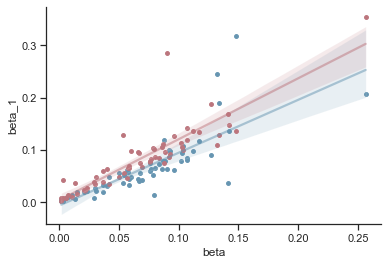

In [18]:
# sns.regplot(x='beta',y='beta_0' ,data=df,
#             line_kws={"color":"darkorange","alpha":0.5},
#             scatter_kws={"color":"darkorange","alpha":0.8,"s":15})
# sns.regplot(x='beta',y='beta_1' ,data=df,
#             line_kws={"color":"darkviolet","alpha":0.5},
#             scatter_kws={"color":"darkviolet","alpha":0.8,"s":15})
# plt.plot(beta,beta,c='grey',linestyle='dashdot',alpha=0.4)
# sns.set(style='ticks')
# sns.despine()
sns.regplot(x='beta',y='beta_0' ,data=df,
            line_kws={"color":(102/255,149/255,177/255),"alpha":0.5},
            scatter_kws={"color":(102/255,149/255,177/255),"alpha":1,"s":15})
sns.regplot(x='beta',y='beta_1' ,data=df,
            line_kws={"color":(188/255,117/255,125/255),"alpha":0.5},
            scatter_kws={"color":(188/255,117/255,125/255),"alpha":1,"s":15})
# plt.plot(beta,beta,c='grey',linestyle='dashdot')

plt.yticks([0,0.10,0.20,0.30])


sns.set(style='ticks')
sns.despine()

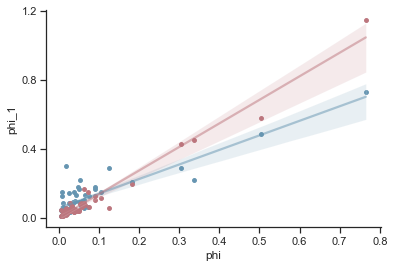

In [20]:
sns.set(style='ticks')
sns.despine()
sns.regplot(x='phi',y='phi_0' ,data=df,
            line_kws={"color":(102/255,149/255,177/255),"alpha":0.5},
            scatter_kws={"color":(102/255,149/255,177/255),"alpha":1,"s":15})
sns.regplot(x='phi',y='phi_1' ,data=df,
            line_kws={"color":(188/255,117/255,125/255),"alpha":0.5},
            scatter_kws={"color":(188/255,117/255,125/255),"alpha":1,"s":15})
# plt.plot(phi,phi,c='grey',linestyle='dotted')

plt.yticks([0,0.40,0.80,1.20])

sns.set(style='ticks')
sns.despine()

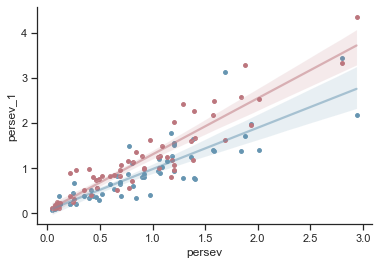

In [12]:
sns.set(style='ticks')
sns.despine()
sns.regplot(x='persev',y='persev_0' ,data=df,
            line_kws={"color":(102/255,149/255,177/255),"alpha":0.5},
            scatter_kws={"color":(102/255,149/255,177/255),"alpha":1,"s":15})
sns.regplot(x='persev',y='persev_1' ,data=df,
            line_kws={"color":(188/255,117/255,125/255),"alpha":0.5},
            scatter_kws={"color":(188/255,117/255,125/255),"alpha":1,"s":15})
# plt.plot(persev,persev,c='grey',linestyle='dotted')
sns.set(style='ticks')
sns.despine()

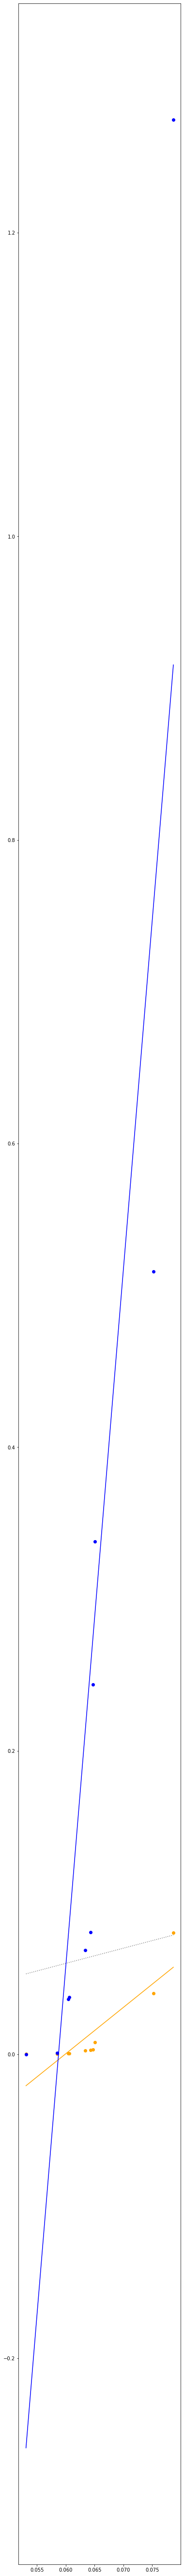

In [249]:
plt.figure(figsize=(6,6*max(np.max(beta_0),np.max(beta_1))/np.max(beta)))
plt.plot(beta,beta,c='grey',linestyle='dotted')
plt.scatter(beta,beta_0,c='orange')
plt.scatter(beta,beta_1,c='blue')
par_0 = np.polyfit(beta,beta_0.squeeze(),1)
par_1 = np.polyfit(beta,beta_1.squeeze(),1)
y_0 = par_0[0] * beta  + par_0[1]
y_1 = par_1[0] * beta  + par_1[1]
plt.plot(beta,y_0,c='orange')
plt.plot(beta,y_1,c='blue')

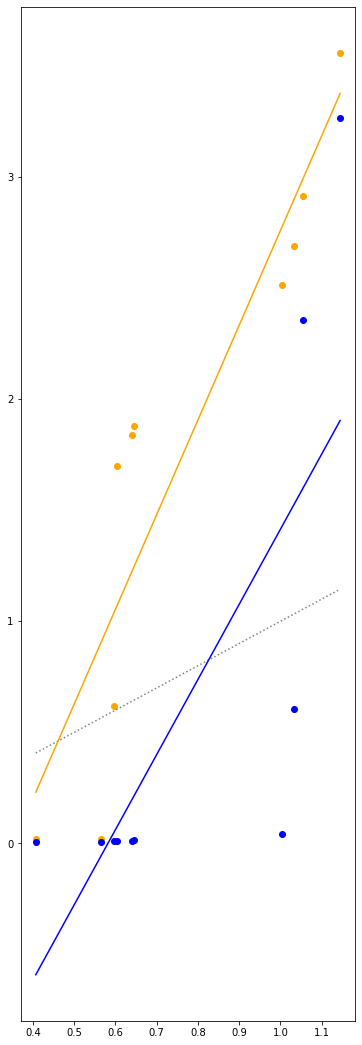

In [250]:
plt.figure(figsize=(6,6*max(np.max(phi_0),np.max(phi_1))/np.max(phi)))
plt.plot(phi,phi,c='grey',linestyle='dotted')
plt.scatter(phi,phi_0,c='orange')
plt.scatter(phi,phi_1,c='blue')
par_0 = np.polyfit(phi,phi_0.squeeze(),1)
par_1 = np.polyfit(phi,phi_1.squeeze(),1)
y_0 = par_0[0] * phi  + par_0[1]
y_1 = par_1[0] * phi  + par_1[1]
plt.plot(phi,y_0,c='orange')
plt.plot(phi,y_1,c='blue')

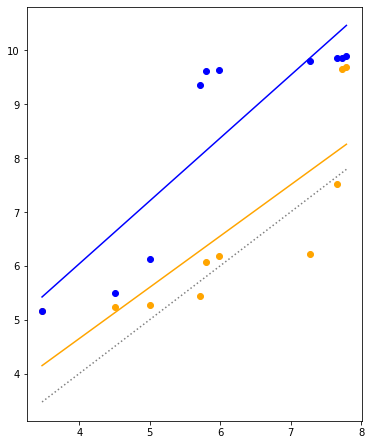

In [251]:
plt.figure(figsize=(6,6*max(np.max(persev_0),np.max(persev_1))/np.max(persev)))
plt.plot(persev,persev,c='grey',linestyle='dotted')
plt.scatter(persev,persev_0,c='orange')
plt.scatter(persev,persev_1,c='blue')
par_0 = np.polyfit(persev,persev_0.squeeze(),1)
par_1 = np.polyfit(persev,persev_1.squeeze(),1)
y_0 = par_0[0] * persev  + par_0[1]
y_1 = par_1[0] * persev  + par_1[1]
plt.plot(persev,y_0,c='orange')
plt.plot(persev,y_1,c='blue')

[]

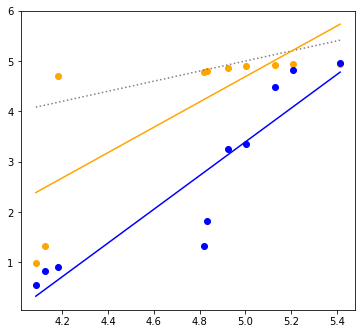

In [252]:
plt.figure(figsize=(6,6*max(np.max(gamma_0),np.max(gamma_1))/np.max(gamma)))
plt.plot(gamma,gamma,c='grey',linestyle='dotted')
plt.scatter(gamma,gamma_0,c='orange')
plt.scatter(gamma,gamma_1,c='blue')
par_0 = np.polyfit(gamma,gamma_0.squeeze(),1)
par_1 = np.polyfit(gamma,gamma_1.squeeze(),1)
y_0 = par_0[0] * gamma  + par_0[1]
y_1 = par_1[0] * gamma  + par_1[1]
plt.plot(gamma,y_0,c='orange')
plt.plot(gamma,y_1,c='blue')
plt.plot()